<a href="https://colab.research.google.com/github/nicholas-dinicola/Forecasting-stock-prices-based-on-semantic-analysis-of-business-news-and-social-media-posts-/blob/main/LSTM_Stocks%2BUSE%2BPolarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sktime
!pip install keras-tuner

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas_datareader as pdr
from datetime import datetime
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import time
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import tensorflow_hub as hub
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, AlphaDropout, LSTM, Dropout 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from kerastuner import BayesianOptimization, RandomSearch, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
# Mean Directional Accuracy
def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

# Load the TSLA Historical Price Data 

In [ ]:
# Tesla
start_date = "2016/01/01"
end_date = "2021/05/01"

tlsa_stock = pdr.data.get_data_yahoo("TSLA", start=start_date, end = end_date)
tlsa_stock.head(), tlsa_stock.shape

(                 High        Low       Open      Close      Volume  Adj Close
 Date                                                                         
 2016-01-04  46.276001  43.799999  46.144001  44.681999  34135500.0  44.681999
 2016-01-05  45.377998  44.000000  45.271999  44.686001  15934000.0  44.686001
 2016-01-06  44.009998  43.195999  44.000000  43.807999  18895500.0  43.807999
 2016-01-07  43.688000  42.734001  42.838001  43.130001  17771500.0  43.130001
 2016-01-08  44.088001  42.153999  43.571999  42.200001  18140500.0  42.200001,
 (1341, 6))

# Reddit Submissions

In [ ]:
tesla = pd.read_csv("/content/drive/MyDrive/reddit_queries-TSLA stock-2016-01-01-2021-05-01-submission.csv", usecols=["created", "text", "polarity"])

tesla.head()

,created,text,polarity
0,2016-01-04 18:56:15,Why the TSLA Stock Price Dropped 7% Today,0.000000
1,2016-01-07 17:03:55,How will the Chinese market effect TSLA stock?,0.000000
2,2016-01-09 01:22:58,If you feel a stock will rise significantly wh...,0.437500
3,2016-01-10 09:00:21,Some help with respective growth,0.000000
4,2016-01-14 01:39:10,"New to investing - how does a stock being ""ove...",0.136364


In [ ]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11175 entries, 0 to 11174
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   created   11175 non-null  object 
 1   text      11175 non-null  object 
 2   polarity  11175 non-null  float64
dtypes: float64(1), object(2)
memory usage: 262.0+ KB


In [ ]:
# Convert the Created column to the correct datatype
tesla["created"] = pd.to_datetime(tesla["created"], format="%Y-%m-%d %X")

# Rename the column to Date eeee
tesla.rename(columns={
                      "created": "Date", 
                      "text": "Text", 
                      "polarity": "Polarity"
                      }, 
                      inplace=True
                      )

# Delite the time from the date 
tesla["Date"] = tesla["Date"].dt.date

# Set date as the index 
#tesla.set_index("date", inplace=True)

tesla.head()

,Date,Text,Polarity
0,2016-01-04,Why the TSLA Stock Price Dropped 7% Today,0.000000
1,2016-01-07,How will the Chinese market effect TSLA stock?,0.000000
2,2016-01-09,If you feel a stock will rise significantly wh...,0.437500
3,2016-01-10,Some help with respective growth,0.000000
4,2016-01-14,"New to investing - how does a stock being ""ove...",0.136364


In [ ]:
tesla.isnull().sum()

Date        0
Text        0
Polarity    0
dtype: int64

## *Text Processing* 

In [ ]:
print(f"Original dataset: {tesla.shape}")
# Drop duplicate submissions 
tesla.drop_duplicates(subset=["Text"], inplace=True)

print(f"Dropped Duplicates: {tesla.shape}")

Original dataset: (11175, 3)
Dropped Duplicates: (9422, 3)


In [ ]:
# Drop submission containing words: I, me, my 
tesla_cleaned = tesla[~tesla["Text"].str.contains("|".join(["I", "me", "my", "Me", "My"]))]
tesla_cleaned.shape

(5564, 3)

## *Universal Sentence Encoder - Transformer Neural Network*

In [ ]:
# load the model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
# Embed the text 
embeddings = embed(tesla_cleaned["Text"])
embeddings

<tf.Tensor: shape=(5564, 512), dtype=float32, numpy=
array([[ 0.04345561, -0.11120632,  0.0392824 , ..., -0.05267137,
        -0.02853704,  0.03992588],
       [ 0.05424882, -0.10001906,  0.00567574, ..., -0.06127235,
        -0.01982329,  0.05274871],
       [ 0.03904071, -0.06860577,  0.01309197, ..., -0.09000869,
        -0.01731981,  0.01975583],
       ...,
       [ 0.04847562, -0.06918481,  0.01885642, ..., -0.11346151,
         0.00420032,  0.06121937],
       [ 0.02811337, -0.09642214, -0.03425785, ...,  0.0287071 ,
         0.00932992,  0.04918296],
       [ 0.05211928, -0.01738226, -0.0303201 , ..., -0.03761019,
         0.05486578,  0.06084001]], dtype=float32)>

In [ ]:
# Similarity
sim_matrix = np.inner(embeddings, embeddings)
sim_matrix

array([[0.99999976, 0.65476435, 0.4647224 , ..., 0.19412838, 0.24112663,
        0.27285296],
       [0.65476435, 0.99999976, 0.5148665 , ..., 0.21957844, 0.2563796 ,
        0.24683443],
       [0.4647224 , 0.5148665 , 0.9999998 , ..., 0.20974061, 0.1857818 ,
        0.16128166],
       ...,
       [0.19412838, 0.21957844, 0.20974061, ..., 0.9999999 , 0.17004207,
        0.35178077],
       [0.24112663, 0.2563796 , 0.1857818 , ..., 0.17004207, 0.9999997 ,
        0.35338062],
       [0.27285296, 0.24683443, 0.16128166, ..., 0.35178077, 0.35338062,
        1.        ]], dtype=float32)

In [ ]:
"""for i, t in enumerate(tesla_cleaned["Text"]):
    print(t)
    most_similar_idx = (-sim_matrix[i]).argsort()[1:2][0]
    print(">", tesla_cleaned["Text"][most_similar_idx])
    print("-"*10)"""

'for i, t in enumerate(tesla_cleaned["Text"]):\n    print(t)\n    most_similar_idx = (-sim_matrix[i]).argsort()[1:2][0]\n    print(">", tesla_cleaned["Text"][most_similar_idx])\n    print("-"*10)'

In [ ]:
# Tensorflow embeddings to numpy array  
embeddings_array = embeddings.numpy()

# Add the arrays in a Dataframe with shape 5564, 512
df_embed = pd.DataFrame(embeddings_array)
df_embed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,0.011030,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
1,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,0.058692,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749
2,0.039041,-0.068606,0.013092,0.013186,0.011777,0.053128,0.049630,-0.011028,-0.009169,-0.061917,-0.095366,-0.024638,0.013540,-0.048794,-0.053915,-0.039160,-0.027672,0.130044,0.005325,-0.014104,-0.015254,-0.058375,-0.034113,-0.013018,-0.021983,0.080600,-0.019517,-0.003290,-0.044261,-0.009982,0.001874,-0.046344,-0.029175,0.057330,-0.010548,-0.034735,-0.053951,-0.034200,0.007441,-0.017942,...,-0.010447,-0.055492,0.029378,-0.020099,0.031322,0.017011,-0.074546,-0.016870,-0.015041,-0.047478,-0.018918,-0.047059,0.024833,-0.030533,-0.017832,0.019946,-0.044420,0.051010,0.024190,0.034760,-0.059374,-0.024289,0.021733,-0.070944,0.030421,-0.037816,-0.010248,-0.047548,0.043420,-0.005086,-0.000886,-0.033570,-0.006017,0.094140,-0.009295,-0.018683,0.001048,-0.090009,-0.017320,0.019756
3,-0.009967,-0.035609,-0.008195,-0.007284,0.071491,0.080406,-0.018711,0.050389,0.049763,0.014613,-0.038105,-0.026422,-0.026849,-0.024531,-0.007536,-0.062754,-0.015467,0.037873,-0.016769,0.045723,0.013568,0.019464,-0.086083,-0.044683,0.022927,0.015548,0.028186,-0.030208,0.024603,0.013101,-0.015893,-0.024774,0.005423,0.034380,0.016798,-0.027982,-0.001000,0.020535,-0.036618,0.007104,...,-0.002111,0.004016,0.060379,0.041406,-0.057623,-0.034787,-0.091569,0.062442,-0.038889,-0.012533,0.037532,0.060343,-0.046770,-0.051474,-0.079687,-0.016569,-0.024608,0.020597,-0.033194,-0.022631,-0.035089,0.038708,-0.027579,0.072803,0.007596,-0.020384,0.006752,-0.053086,-0.039699,0.040344,0.020259,0.014487,-0.014378,0.033963,-0.031939,-0.008462,-0.016819,-0.050620,0.033360,0.070762
4,0.041209,-0.126977,0.017845,0.070324,0.053150,0.093336,0.006642,0.000792,0.052400,-0.014364,-0.056320,0.002642,0.074355,0.026473,0.011149,-0.030655,-0.082812,-0.032159,-0.019585,-0.013274,0.017406,-0.060616,-0.007950,0.003047,-0.029943,0.045619,-0.050423,0.033763,-0.051173,-0.024855,0.013357,-0.019299,-0.012811,-0.031723,-0.012873,-0.049357,-0.042473,-0.042564,0.041365,0.044715,...,0.031905,-0.046167,0.035104,0.085450,-0.003483,-0.034634,-0.075975,-0.008378,-0.053551,-0.019567,-0.036106,0.013044,-0.005139,-0.021327,-0.060650,0.033208,-0.011678,0.004247,-0.070856,-0.036247,-0.033178,0.046641,0.019139,-0.000279,0.048948,-0.087329

## *Join the Embedded Dataframe with the Reddit one*

In [ ]:
tesla_cleaned.shape, df_embed.shape

((5564, 3), (5564, 512))

In [ ]:
# Drop the original text column from the Tesla dataset 
tesla_NoText = tesla_cleaned.drop(["Text"], axis=1)

# Combine the embedded text dataset with the Tesla dataset
tesla_embed = pd.concat([tesla_NoText.reset_index(), df_embed], axis=1)

# Drop the index 
tesla_embed.drop(["index"], axis=1, inplace=True)

# Expecting a shape of 5564, 514
tesla_embed.shape == (5564, 514)

True

In [ ]:
# See the head of the embedded tesla dataset
tesla_embed

,Date,Polarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,2016-01-04,0.000000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
1,2016-01-07,0.000000,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749
2,2016-01-14,0.136364,0.039041,-0.068606,0.013092,0.013186,0.011777,0.053128,0.049630,-0.011028,-0.009169,-0.061917,-0.095366,-0.024638,0.013540,-0.048794,-0.053915,-0.039160,-0.027672,0.130044,0.005325,-0.014104,-0.015254,-0.058375,-0.034113,-0.013018,-0.021983,0.080600,-0.019517,-0.003290,-0.044261,-0.009982,0.001874,-0.046344,-0.029175,0.057330,-0.010548,-0.034735,-0.053951,-0.034200,...,-0.010447,-0.055492,0.029378,-0.020099,0.031322,0.017011,-0.074546,-0.016870,-0.015041,-0.047478,-0.018918,-0.047059,0.024833,-0.030533,-0.017832,0.019946,-0.044420,0.051010,0.024190,0.034760,-0.059374,-0.024289,0.021733,-0.070944,0.030421,-0.037816,-0.010248,-0.047548,0.043420,-0.005086,-0.000886,-0.033570,-0.006017,0.094140,-0.009295,-0.018683,0.001048,-0.090009,-0.017320,0.019756
3,2016-01-17,0.500000,-0.009967,-0.035609,-0.008195,-0.007284,0.071491,0.080406,-0.018711,0.050389,0.049763,0.014613,-0.038105,-0.026422,-0.026849,-0.024531,-0.007536,-0.062754,-0.015467,0.037873,-0.016769,0.045723,0.013568,0.019464,-0.086083,-0.044683,0.022927,0.015548,0.028186,-0.030208,0.024603,0.013101,-0.015893,-0.024774,0.005423,0.034380,0.016798,-0.027982,-0.001000,0.020535,...,-0.002111,0.004016,0.060379,0.041406,-0.057623,-0.034787,-0.091569,0.062442,-0.038889,-0.012533,0.037532,0.060343,-0.046770,-0.051474,-0.079687,-0.016569,-0.024608,0.020597,-0.033194,-0.022631,-0.035089,0.038708,-0.027579,0.072803,0.007596,-0.020384,0.006752,-0.053086,-0.039699,0.040344,0.020259,0.014487,-0.014378,0.033963,-0.031939,-0.008462,-0.016819,-0.050620,0.033360,0.070762
4,2016-01-20,-0.077778,0.041209,-0.126977,0.017845,0.070324,0.053150,0.093336,0.006642,0.000792,0.052400,-0.014364,-0.056320,0.002642,0.074355,0.026473,0.011149,-0.030655,-0.082812,-0.032159,-0.019585,-0.013274,0.017406,-0.060616,-0.007950,0.003047,-0.029943,0.045619,-0.050423,0.033763,-0.051173,-0.024855,0.013357,-0.019299,-0.012811,-0.031723,-0.012873,-0.049357,-0.042473,-0.042564,...,0.031905,-0.046167,0.035104,0.085450,-0.003483,-0.034634,-0.075975,-0.008378,-0.053551,-0.019567,-0.036106,0.013044,-0.005139,-0.021327,-0.060650,0.033208,-0.011678,0.004247,-0.070856,-0.036247,-0.033178,0.046641,0.019139,-0.000279,0

In [ ]:
# Convert the Date column to a datetime object 
tesla_embed["Date"] = pd.to_datetime(tesla_embed["Date"], format="%Y-%m-%d")
tesla_embed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Columns: 514 entries, Date to 511
dtypes: datetime64[ns](1), float32(512), float64(1)
memory usage: 11.0 MB


## *Join the Tesla embedded dataset with the TLSA Historical price dataset*

In [ ]:
# Create a list of all possible dates 
start_date = "2016-01-04"
end_date = "2021/05/01"
my_dates = pd.date_range(start=start_date, end=end_date)

# Store the list of dates in a dateframe 
df_date = pd.DataFrame(my_dates).rename(columns={0: "Date"})
df_date

,Date
0,2016-01-04
1,2016-01-05
2,2016-01-06
3,2016-01-07
4,2016-01-08
...,...
1940,2021-04-27
1941,2021-04-28
1942,2021-04-29
1943,2021-04-30


In [ ]:
# Merge the Date Df with the tesla Embed to obtain a dataset with all possible dates 
tesla_date_embed = df_date.merge(tesla_embed, on="Date", how="outer")
tesla_date_embed

,Date,Polarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,2016-01-04,0.000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
1,2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,0.000,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749
4,2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,2021-04-30,0.125,0.096124,-0.113736,0.031400,0.055952,0.034415,0.001893,-0.052301,0.090091,0.047590,-0.066928,-0.006521,-0.000326,0.015918,-0.012617,0.031136,0.008900,-0.022014,0.013384,0.029436,-0.023745,0.014494,0.031067,-0.039871,-0.075966,-0.019239,-0.024861,-0.032997,-0.015750,-0.002737,-0.018983,0.041923,-0.068143,-0.024910,-0.007335,-0.019715,-0.048310,-0.021443,-0.031209,...,0.023137,-0.021039,-0.024418,0.081669,-0.009065,-0.023042,-0.102104,-0.024408,-0.076611,-0.011579,-0.000784,-0.033904,-0.025732,0.045472,-0.038005,0.021686,0.055202,0.071206,-0.038918,0.021647,-0.012942,-0.004659,0.028206,0.065892,-0.010352,-0.098773,-0.082373,-0.050107,0.073422,-0.008891,0.012251,0.036458,-0.011934,-0.004669,0.068999,0.046711,-0.047314,-0.054470,-0.024180,-0.003717
6284,2021-04-30,0.200,0.005917,-0.095915,0.036277,0.009219,0.054792,0.060929

In [ ]:
# The tlsa_stoco df is indexed by the Date and we need it for the join, 
# thereby we need to reset the index and filter the dataset only by the  variable we are interested 

tlsa_stock = tlsa_stock["Close"].reset_index()

# Left join tlsa_stock with tesla_date_embed 
tesla_merged = tesla_date_embed.merge(tlsa_stock, on="Date", how="left")
tesla_merged

,Date,Polarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,Close
0,2016-01-04,0.000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,44.681999
1,2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.686001
2,2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.807999
3,2016-01-07,0.000,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,...,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749,43.130001
4,2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,2021-04-30,0.125,0.096124,-0.113736,0.031400,0.055952,0.034415,0.001893,-0.052301,0.090091,0.047590,-0.066928,-0.006521,-0.000326,0.015918,-0.012617,0.031136,0.008900,-0.022014,0.013384,0.029436,-0.023745,0.014494,0.031067,-0.039871,-0.075966,-0.019239,-0.024861,-0.032997,-0.015750,-0.002737,-0.018983,0.041923,-0.068143,-0.024910,-0.007335,-0.019715,-0.048310,-0.021443,-0.031209,...,-0.021039,-0.024418,0.081669,-0.009065,-0.023042,-0.102104,-0.024408,-0.076611,-0.011579,-0.000784,-0.033904,-0.025732,0.045472,-0.038005,0.021686,0.055202,0.071206,-0.038918,0.021647,-0.012942,-0.004659,0.028206,0.065892,-0.010352,-0.098773,-0.082373,-0.050107,0.073422,-0.008891,0.012251,0.036458,-0.011934,-0.004669,0.068999,0.046711,-0.047314,-0.054470,-0.024180,-0.003717,709.440002
6284,2021-04-30,0.200,0.005917,-0.095915,0.036277,0.

## *Clean up the Final Dataset*

We need to obtain a dataset with only a representation of a single day for each day. Hence, we can group by date taking the mean of all the other numerical columns. 

In [ ]:
# Group by date taking the mean for the other columns 
tesla_grouped = tesla_merged.groupby("Date").mean()
tesla_grouped

,Polarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.000000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,44.681999
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.686001
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.807999
2016-01-07,0.000000,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,...,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749,43.130001
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-27,0.123897,0.036748,-0.064050,0.020770,0.023711,0.028461,0.039785,0.011946,-0.021782,0.003866,-0.001729,-0.058599,-0.010909,0.038639,0.004702,0.004208,-0.007143,-0.044755,0.033188,-0.011559,-0.001541,-0.001854,-0.032107,0.016191,-0.006134,0.006185,0.037061,-0.013754,0.015708,-0.037747,0.023962,-0.003169,0.006475,0.018003,-0.023645,0.003695,-0.009469,0.005332,-0.018112,0.020418,...,-0.021406,0.006375,0.029276,-0.013574,-0.016178,0.030707,-0.005734,-0.019706,0.000747,-0.003351,-0.019091,0.009024,0.001534,-0.011578,0.005528,-0.014336,0.041471,-0.009538,-0.013726,0.005445,0.003778,-0.000229,-0.029696,0.017594,-0.027324,-0.027346,-0.041524,0.011463,-0.029961,0.013870,-0.004220,-0.032630,0.010782,0.017406,0.0

### *Missing Values*

In [ ]:
# Foward fill missing values 
final_tesla = tesla_grouped.fillna(method="ffill", axis=0)
final_tesla

,Polarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.000000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,44.681999
2016-01-05,0.000000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,44.686001
2016-01-06,0.000000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,43.807999
2016-01-07,0.000000,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,...,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749,43.130001
2016-01-08,0.000000,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,...,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-

In [ ]:
final_tesla.isnull().any().sum()

0

Text(0.5, 1.0, 'TSLA Close Stock Price')

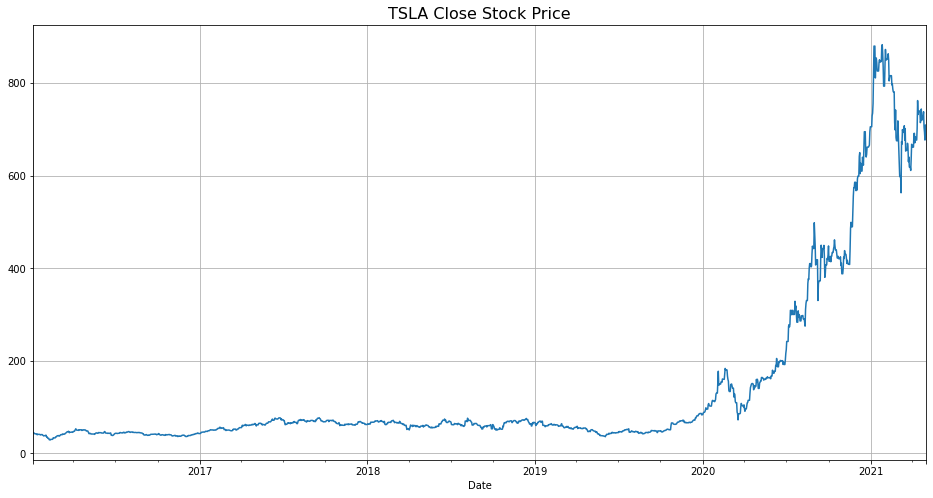

In [ ]:
final_tesla["Close"].plot(figsize=(16, 8))
plt.grid(True)
plt.title("TSLA Close Stock Price", fontsize=16)

Data after 2020/01/01 became too volatile, thereby i will not include those data in the model. 

In [ ]:
final_tesla = final_tesla[final_tesla.index < "2019/09/01"]
final_tesla.index.min(), final_tesla.index.max()

(Timestamp('2016-01-04 00:00:00'), Timestamp('2019-08-31 00:00:00'))

In [ ]:
final_tesla.shape

(1336, 514)

# Stock Price + Text Embeddings + Polarity Score

# TRAIN TEST SPLIT

In [ ]:
train_set, test_set = train_test_split(final_tesla, test_size=0.1, random_state=42, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

1202 train and 134 test instances


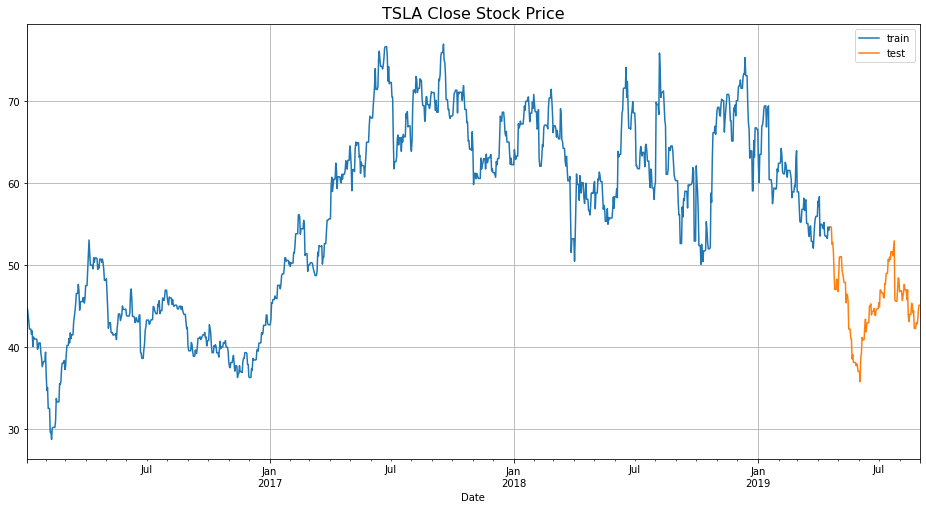

In [ ]:
pd.DataFrame({"train":train_set["Close"], "test":test_set["Close"]}).plot(figsize=(16, 8))
plt.title("TSLA Close Stock Price", fontsize=16)
plt.grid(True)

# Data Tranformation

In [ ]:
# Differencing 
train_diff = train_set["Close"].diff().dropna()
adf_pval = adfuller(train_diff)[1]
print(f"ADF, p-value: {adf_pval}")
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff)
print(f"KPSS, p-value: {kpss_pval}")

# Apply differencing to the test set as well 
test_diff = test_set["Close"].diff().dropna()

# chech the shape of them 
train_diff.shape, test_diff.shape

ADF, p-value: 0.0
KPSS, p-value: 0.1


((1201,), (133,))

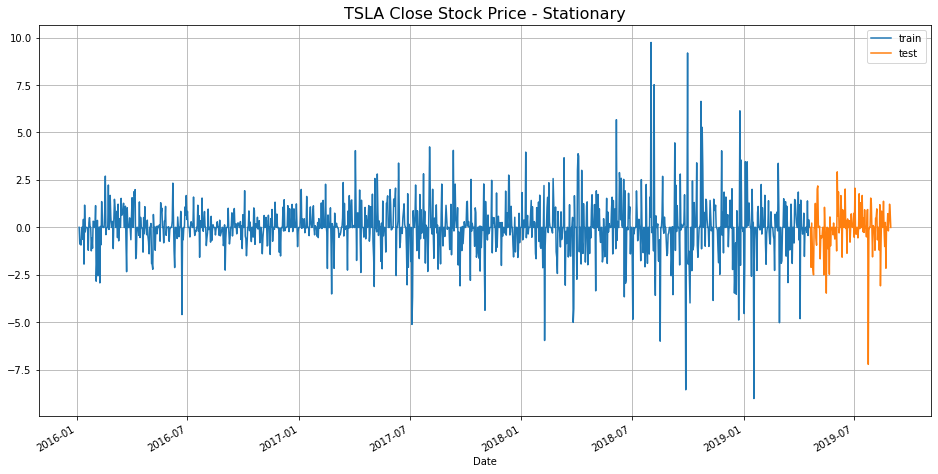

In [ ]:
pd.DataFrame({"train":train_diff, "test":test_diff}).plot(figsize=(16, 8))
plt.title("TSLA Close Stock Price - Stationary", fontsize=16)
plt.grid(True)

There still are some spikes in the data, what would happen if we did the log of them? 


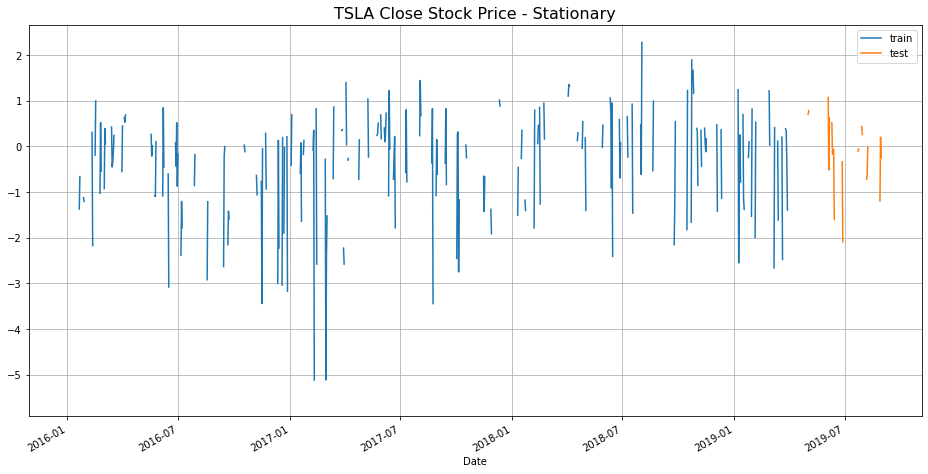

In [ ]:
train_log = np.log(train_diff)
test_log = np.log(test_diff)

pd.DataFrame({"train":train_log, "test":test_log}).plot(figsize=(16, 8))
plt.title("TSLA Close Stock Price - Stationary", fontsize=16)
plt.grid(True)

Some values have ended up neing -/+ inf. We will not use the log then. 

In [ ]:
# 5 days - from monday to friday (stock market is closedsat and sun)
lags = 5
X_train, y_train, X_test, y_test= [], [], [], []

for x in range(lags, len(train_diff.values.reshape(-1, 1))):
    X_train.append(train_diff.values.reshape(-1, 1)[x-lags:x, 0])
    y_train.append(train_diff.values.reshape(-1, 1)[x, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

for x in range(lags, len(test_diff.values.reshape(-1, 1))):
    X_test.append(test_diff.values.reshape(-1, 1)[x-lags:x, 0])
    y_test.append(test_diff.values.reshape(-1, 1)[x, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1196, 5), (1196,), (128, 5), (128,))

In [ ]:
exog_train = train_set.drop("Close", axis=1)
exog_test = test_set.drop("Close", axis=1)

In [ ]:
X_train = pd.concat([pd.DataFrame(X_train), exog_train.reset_index()], axis=1).drop("Date", axis=1).dropna()
X_test = pd.concat([pd.DataFrame(X_test), exog_test.reset_index()], axis=1).drop("Date", axis=1).dropna()

In [ ]:
X_train.head()

,0,1,2,3,4,Polarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.004002,-0.878002,-0.677998,-0.930000,0.000000,0.0,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.03156,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
1,-0.878002,-0.677998,-0.930000,0.000000,0.000000,0.0,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.03156,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
2,-0.677998,-0.930000,0.000000,0.000000,-0.630001,0.0,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.03156,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
3,-0.930000,0.000000,0.000000,-0.630001,0.424000,0.0,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.05065,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749
4,0.000000,0.000000,-0.630001,0.424000,-1.931999,0.0,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.05065,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.0057

In [ ]:
X_test.head()

,0,1,2,3,4,Polarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.000000,-2.102001,0.230000,-1.048000,-2.205997,0.250,0.012351,-0.048884,-0.029511,0.002351,0.079867,0.088463,-0.041595,-0.031075,0.005357,-0.001092,-0.081590,0.061461,0.066473,0.018055,0.053832,0.022355,-0.036107,-0.089072,0.048733,0.042591,0.012833,0.009269,0.030579,0.070454,-0.017943,0.047763,0.076287,-0.024580,-0.045648,-0.006835,0.016161,0.032915,-0.006397,0.018000,...,0.041147,0.008765,0.032990,-0.020962,-0.019238,-0.004653,-0.035901,-0.035397,-0.041130,-0.025106,-0.002492,-0.028935,-0.035789,0.043580,-0.040088,-0.048624,-0.039557,0.082903,-0.068949,-0.042432,-0.027293,0.092440,-0.031290,0.006125,0.028106,-0.036478,-0.047552,-0.000717,0.008272,0.032810,0.054049,0.035661,-0.029676,-0.035063,0.028572,0.018392,0.013183,-0.017984,0.040852,0.055679
1,-2.102001,0.230000,-1.048000,-2.205997,-2.498001,0.250,0.012351,-0.048884,-0.029511,0.002351,0.079867,0.088463,-0.041595,-0.031075,0.005357,-0.001092,-0.081590,0.061461,0.066473,0.018055,0.053832,0.022355,-0.036107,-0.089072,0.048733,0.042591,0.012833,0.009269,0.030579,0.070454,-0.017943,0.047763,0.076287,-0.024580,-0.045648,-0.006835,0.016161,0.032915,-0.006397,0.018000,...,0.041147,0.008765,0.032990,-0.020962,-0.019238,-0.004653,-0.035901,-0.035397,-0.041130,-0.025106,-0.002492,-0.028935,-0.035789,0.043580,-0.040088,-0.048624,-0.039557,0.082903,-0.068949,-0.042432,-0.027293,0.092440,-0.031290,0.006125,0.028106,-0.036478,-0.047552,-0.000717,0.008272,0.032810,0.054049,0.035661,-0.029676,-0.035063,0.028572,0.018392,0.013183,-0.017984,0.040852,0.055679
2,0.230000,-1.048000,-2.205997,-2.498001,0.000000,0.000,0.053135,-0.069684,0.002865,0.002929,0.051400,0.056233,0.000444,-0.006952,0.034266,-0.008422,-0.058403,-0.007550,0.045518,0.009066,0.037736,-0.014951,-0.081208,-0.044917,-0.023811,0.021790,0.034840,-0.048141,0.006196,0.003398,-0.021406,0.053474,0.002328,0.014229,-0.044940,-0.030279,-0.001270,-0.006046,-0.012061,-0.025556,...,0.043204,-0.003301,0.019220,0.029932,-0.020258,-0.015427,-0.017764,0.028321,-0.050798,-0.002193,-0.024645,-0.012306,0.016953,-0.000772,-0.023191,0.008080,-0.032231,0.013439,-0.042504,-0.025647,0.005888,0.050861,-0.001436,-0.023230,0.029118,-0.028571,-0.074643,-0.054216,0.048108,-0.025088,0.038798,-0.011818,-0.024925,0.008004,0.027384,0.028089,-0.001453,-0.053520,0.004821,0.068851
3,-1.048000,-2.205997,-2.498001,0.000000,0.000000,0.075,0.043895,-0.071796,0.018554,0.043008,0.031804,0.057881,0.028435,0.008516,0.026964,-0.041773,-0.079219,0.008468,0.053608,0.005831,0.004878,0.011762,-0.059781,0.021679,-0.016572,-0.026522,0.001117,-0.012507,-0.012897,0.021745,0.001406,0.047170,-0.009874,0.002904,-0.048918,-0.016576,0.009678,-0.029835,-0.018258,-0.012238,...,-0.000153,-0.022706,-0.024629,0.027819,0.002880,-0.006320,-0.042670,-0.000124,-0.048148,0.008280,-0.036341,0.009758,-0.012334,-0.007801,0.006493,0.042760,-0.019017,0.022312,-0.018333,-0.011229,0.001249,0.026483,-0.001247,-0.031280,0.018428,-0.035871,-0.063447,-0.033389,0.024540,-0.010707,0.022615,-0.017011,-0.030135,0.007434,0.009808,0.025857,-0.035844,-0.040849,-0.007758,0.059862
4,-2.205997,-2.498001,0.000000,0.000000,1.265999,0.000,0.052671,-0.017777,-0.028143,0.011287,0.042668,0.051811,0.013963,-0.016339,0.019682,0.037333,-0.075926,-0.004873,0.044758,-0.016484,0.017828,0.014669,-0.081284,-0.050079,-0.017797,-0.001852,0.038967,-0.063931,0.041899,0.057804,-0.002235,0.080624,0.041316,0.035085,-0.089815,-0.031415,0.009291,0.018062,0.006420,-0.036891,...,0.057777,-0.004960,0.033977,-0.053270,-0.008010,0.022045,-0.022418,0.045037,-0.070251,0.023030,-0.030778,-0.051663,0.024703,0.060898,-0.022710,0.016244,-0.031374,-0.008327,-0.018338,-0.028968,-0.073060,0.042962,-0.032343,-0.033366,0.046945,-0.032001,-0.057713,-0.066893,0.061411,-0.023751,

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# Modelling

## 1.1 Fine Tuned LSTM got using only the historical stock price data

In [ ]:
#Build the model
model = Sequential()
model.add(LSTM(5,input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(LSTM(3, return_sequences=False))
model.add(Dropout(0.35))
model.add(Dense(1))
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5, 
                    verbose=0
                   )

In [ ]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

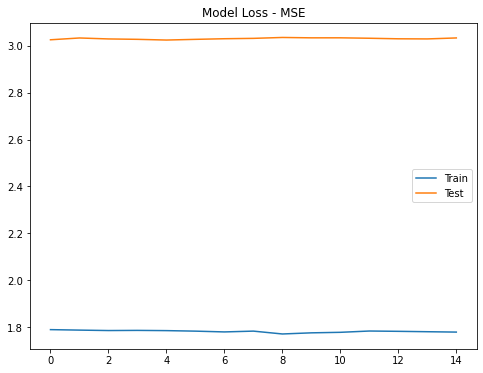

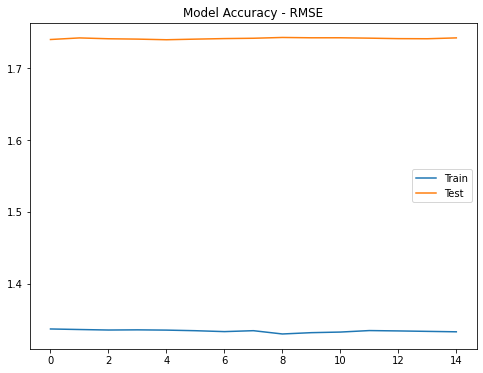

Text(0.5, 1.0, 'Test Dataset')

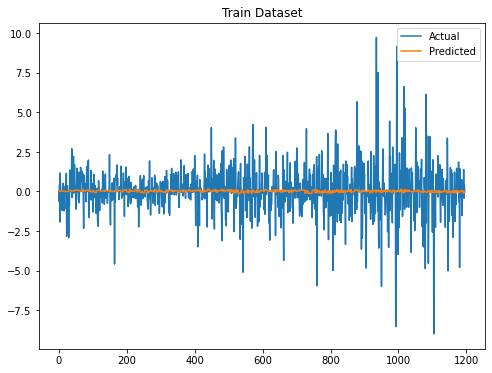

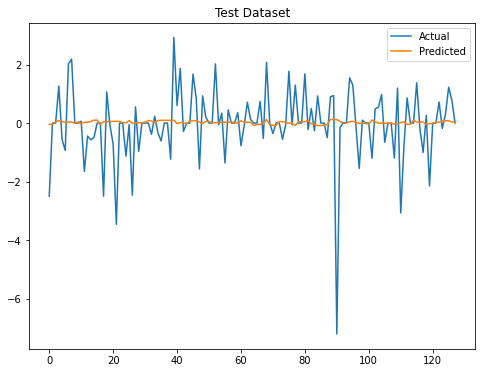

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])

# Make it pretty 
plt.title('Model Accuracy - RMSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 0s 23ms/step - loss: 1.4267 - root_mean_squared_error: 1.1944
rmse score on test set: [1.4266880750656128, 1.194440484046936]
sMAPE score: 1.92354454444457


## 1.2 Previous Fine Tundes LSTM-Without Dropout

In [ ]:
#Build the model
model = Sequential()
model.add(LSTM(5,input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(LSTM(3, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5, 
                    verbose=0
                   )

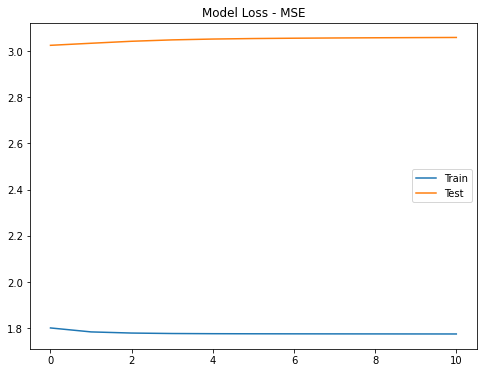

Text(0.5, 1.0, 'Test Dataset')

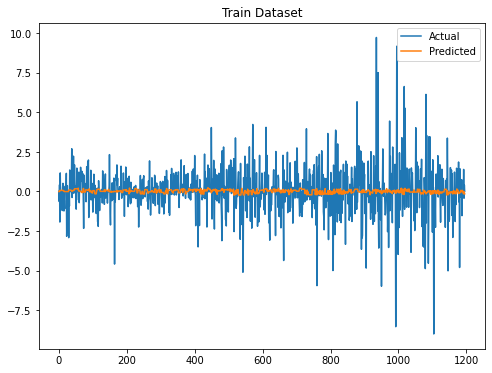

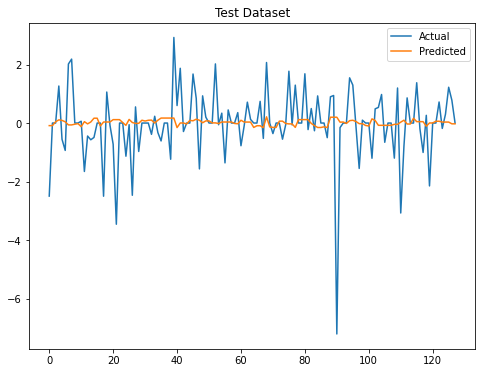

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 1s 23ms/step - loss: 1.4482 - root_mean_squared_error: 1.2034
rmse score on test set: [1.4482322931289673, 1.2034252882003784]
sMAPE score: 1.8707275631650744


Without the dropout layer it starts overfitting. 

## 10, 10, Dropout 0.35



In [ ]:
#Build the model
model = Sequential()
model.add(LSTM(10,input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.35))
model.add(Dense(1))
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5
                   )

Epoch 1/300
216/216 [==============================] - 9s 31ms/step - loss: 1.7886 - root_mean_squared_error: 1.3374 - val_loss: 3.0364 - val_root_mean_squared_error: 1.7425
Epoch 2/300
216/216 [==============================] - 6s 26ms/step - loss: 1.7806 - root_mean_squared_error: 1.3344 - val_loss: 3.0477 - val_root_mean_squared_error: 1.7458
Epoch 3/300
216/216 [==============================] - 6s 26ms/step - loss: 1.7836 - root_mean_squared_error: 1.3355 - val_loss: 3.0470 - val_root_mean_squared_error: 1.7456
Epoch 4/300
216/216 [==============================] - 6s 26ms/step - loss: 1.7723 - root_mean_squared_error: 1.3313 - val_loss: 3.0547 - val_root_mean_squared_error: 1.7478
Epoch 5/300
216/216 [==============================] - 6s 26ms/step - loss: 1.7769 - root_mean_squared_error: 1.3330 - val_loss: 3.0511 - val_root_mean_squared_error: 1.7467
Epoch 6/300
216/216 [==============================] - 6s 26ms/step - loss: 1.7780 - root_mean_squared_error: 1.3334 - val_loss: 3

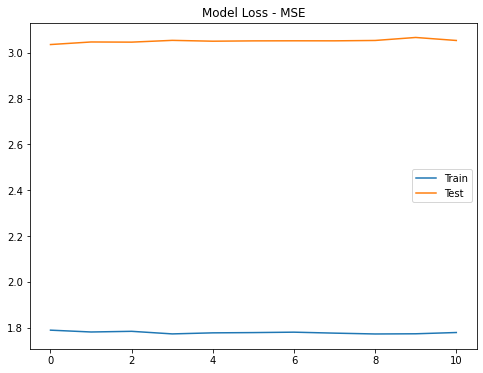

Text(0.5, 1.0, 'Test Dataset')

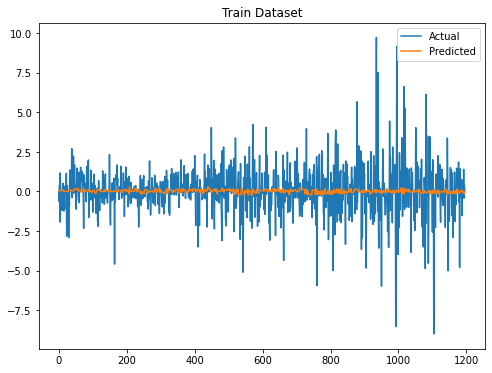

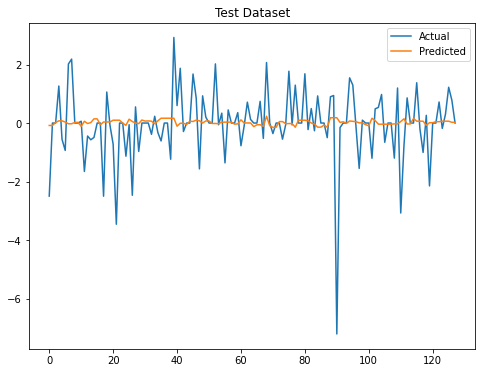

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 1s 26ms/step - loss: 1.4458 - root_mean_squared_error: 1.2024
rmse score on test set: [1.4457714557647705, 1.2024023532867432]
sMAPE score: 1.8837802217978181


it seems to have learned a bit more the the RMSE is higher than before. 

## 1.3 Adding SGD Clipper

In [ ]:
#Build the model
model = Sequential()
model.add(LSTM(10,input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.35))
model.add(Dense(1))
# Set Gradient clipping for exploding vanishing RNN problem 
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0) 
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=optimizer)

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5, 
                    verbose=0
                   )

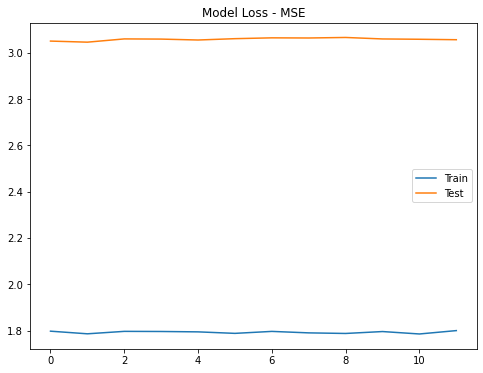

Text(0.5, 1.0, 'Test Dataset')

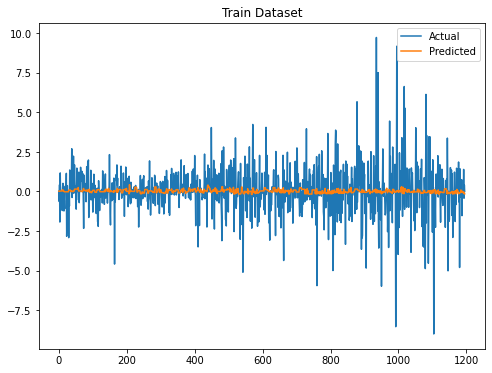

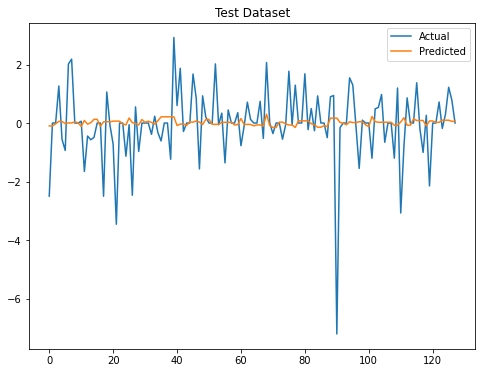

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 1s 23ms/step - loss: 1.4464 - root_mean_squared_error: 1.2027
rmse score on test set: [1.4464342594146729, 1.2026779651641846]
sMAPE score: 1.8410059367242089


No improvements

## Adding layers

In [ ]:
#Build the model
model = Sequential()
model.add(LSTM(5,input_shape=(X_train.shape[1],1), return_sequences=True, activation="relu"))
model.add(Dropout(0.35))
model.add(LSTM(5, return_sequences=True, activation="relu"))
model.add(Dropout(0.35))
model.add(LSTM(5, return_sequences=False,  activation="relu"))
model.add(Dropout(0.35))
model.add(Dense(1))

# Set Gradient clipping for exploding vanishing RNN problem 
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0) 
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=optimizer)

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)

history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping],
                    batch_size=32, 
                    verbose=0
                   )

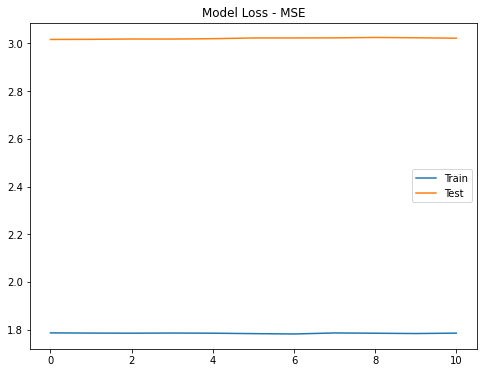

Text(0.5, 1.0, 'Test Dataset')

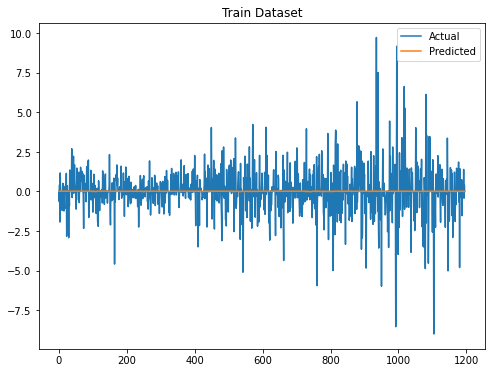

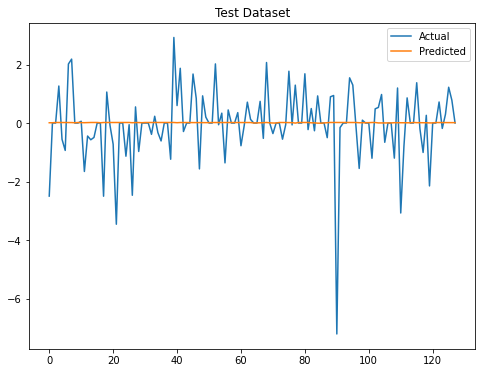

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 1s 173ms/step - loss: 1.4189 - root_mean_squared_error: 1.1912
rmse score on test set: [1.4188594818115234, 1.1911588907241821]
sMAPE score: 1.9622790512440222


## 1.4 USing the same number nodes as the number of columns: 518


In [ ]:
#Build the model
model = Sequential()
model.add(LSTM(518,input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(LSTM(518, return_sequences=False))
model.add(Dropout(0.35))
model.add(Dense(1))
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)

history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping],
                    batch_size=5, 
                    verbose=0
                   )

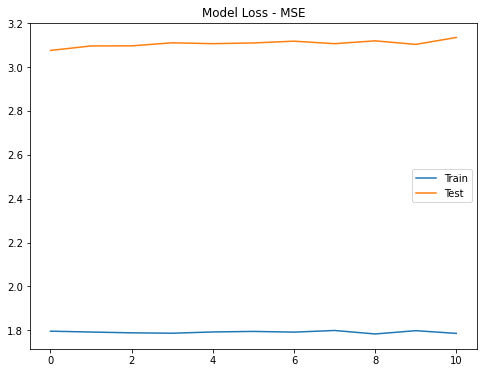

Text(0.5, 1.0, 'Test Dataset')

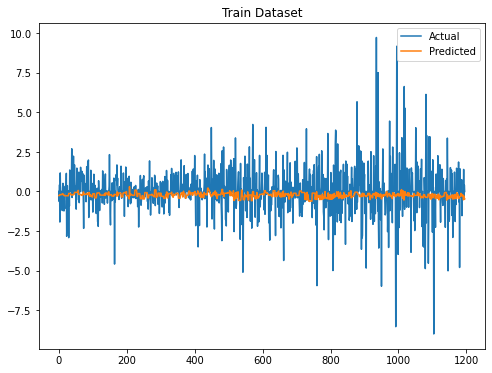

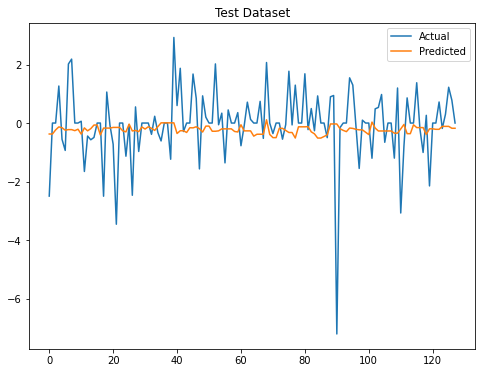

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 1s 74ms/step - loss: 1.4885 - root_mean_squared_error: 1.2200
rmse score on test set: [1.4885165691375732, 1.2200478315353394]
sMAPE score: 1.685374746684215


Seems like the model is overfitting and unable to well generalize on the testing set 

## 1.5 Decrease the number of nodes 

In [ ]:
model = Sequential()
model.add(LSTM(100,input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.35))
model.add(Dense(1))
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5,
                    verbose=0
                   )

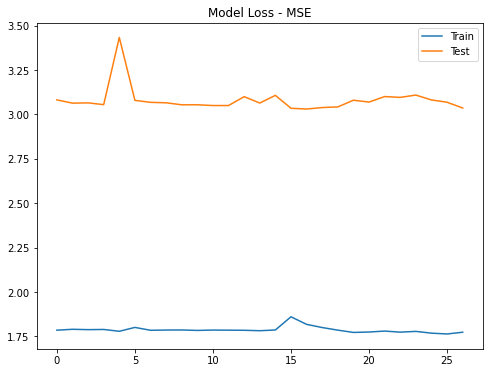

Text(0.5, 1.0, 'Test Dataset')

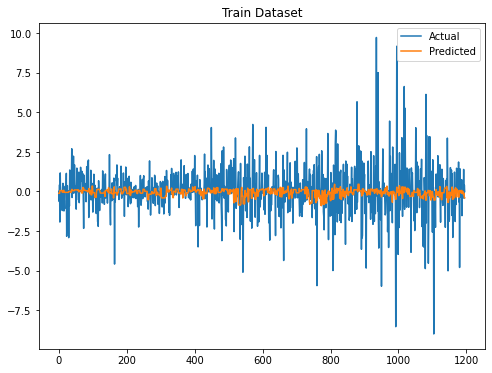

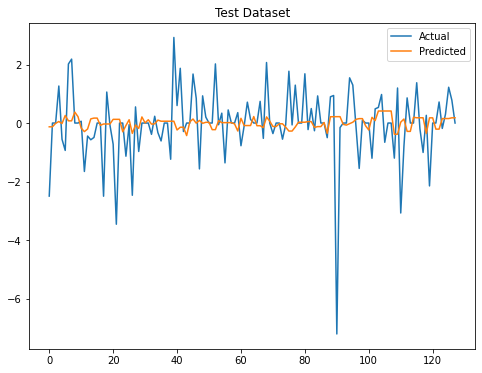

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 1s 33ms/step - loss: 1.4733 - root_mean_squared_error: 1.2138
rmse score on test set: [1.4733092784881592, 1.2137994766235352]
sMAPE score: 1.7773266745524356


## 1.6 BEST MODEL ARCHITECTURE ON STOCK PRICE DATA

In [ ]:
model = Sequential()
model.add(LSTM(400,input_shape=(X_train.shape[1],1), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation="relu"))
# Set Gradient clipping for exploding vanishing RNN problem 
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0) 
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=optimizer)

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5, 
                    verbose=0
                   )

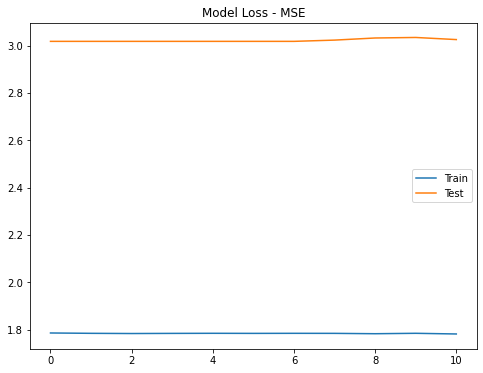

Text(0.5, 1.0, 'Test Dataset')

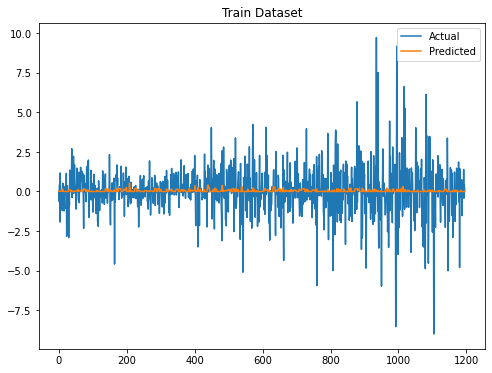

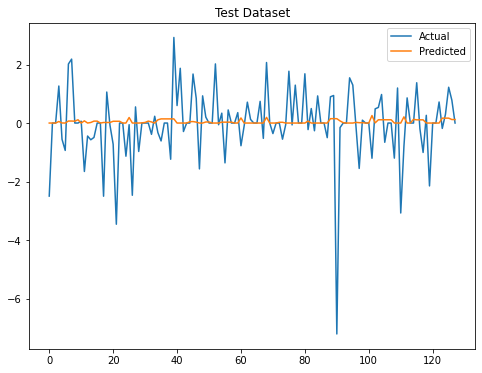

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 0s 35ms/step - loss: 1.4314 - root_mean_squared_error: 1.1964
rmse score on test set: [1.4314239025115967, 1.1964212656021118]
sMAPE score: 1.6100403430496548


Still, the model is overfitting

## 400 HH nodes  + 2 Dropout layers 40% 

In [ ]:
model = Sequential()
model.add(LSTM(500,input_shape=(X_train.shape[1],1), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation="relu"))
# Set Gradient clipping for exploding vanishing RNN problem 
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0) 
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=optimizer)

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5, 
                    verbose=0
                   )

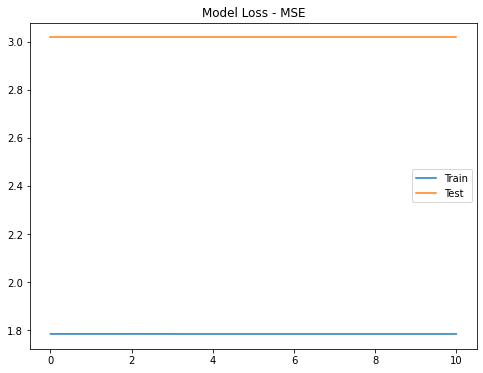

Text(0.5, 1.0, 'Test Dataset')

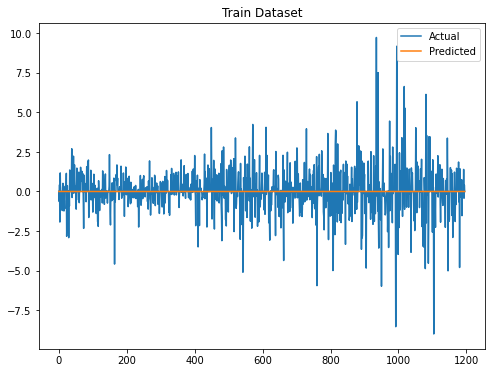

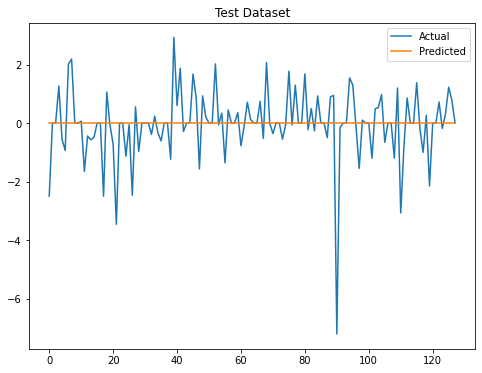

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 0s 40ms/step - loss: 1.4175 - root_mean_squared_error: 1.1906
rmse score on test set: [1.4174580574035645, 1.1905704736709595]
sMAPE score: 1.390625


In [ ]:
y_hat

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [ ]:
y_test

array([-2.4980011 ,  0.        ,  0.        ,  1.26599884, -0.55599976,
       -0.93600082,  2.01800156,  2.18600082,  0.        ,  0.        ,
        0.06200027, -1.65600204, -0.44400024, -0.5719986 , -0.49200058,
        0.        ,  0.        , -2.5019989 ,  1.06000137, -0.07200241,
       -0.72399902, -3.45999908,  0.        ,  0.        , -1.13400269,
       -0.05599976, -2.46999741,  0.55199814, -0.97200012,  0.        ,
        0.        ,  0.        , -0.38599777,  0.23199844, -0.32799911,
       -0.61199951,  0.        ,  0.        , -1.23800278,  2.9260025 ,
        0.59799957,  1.87199783, -0.2899971 ,  0.        ,  0.        ,
        1.67599869,  0.84399796, -1.56799698,  0.93000031,  0.20199966,
        0.        ,  0.        ,  2.02199936, -0.05799866,  0.33799744,
       -1.36199951,  0.44800186,  0.        ,  0.        ,  0.35599899,
       -0.77600098, -0.09799957,  0.7140007 ,  0.12400055,  0.        ,
        0.        ,  0.74199677, -0.52399826,  2.06999969,  0.  

It was working at the beggining, then it started overfitting again. 

## 1.8 600 nodes, dropoout 40%

In [ ]:
model = Sequential()
model.add(LSTM(600,input_shape=(X_train.shape[1],1), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation="relu"))
# Set Gradient clipping for exploding vanishing RNN problem 
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0) 
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=optimizer)

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5, 
                    verbose=0
                   )

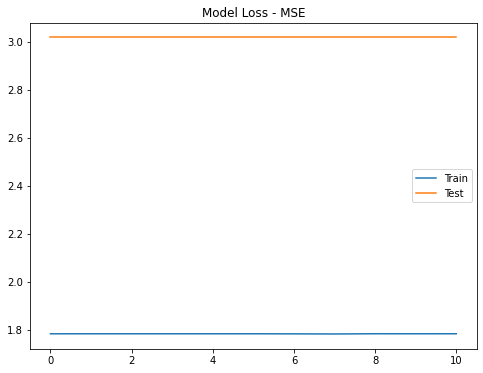

Text(0.5, 1.0, 'Test Dataset')

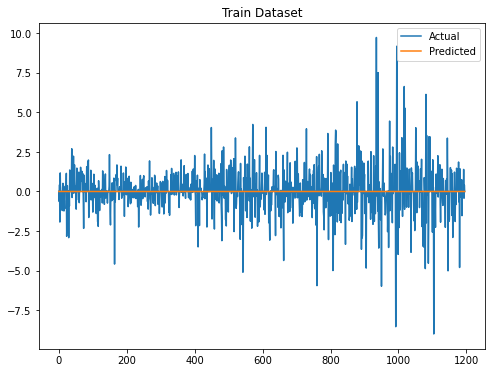

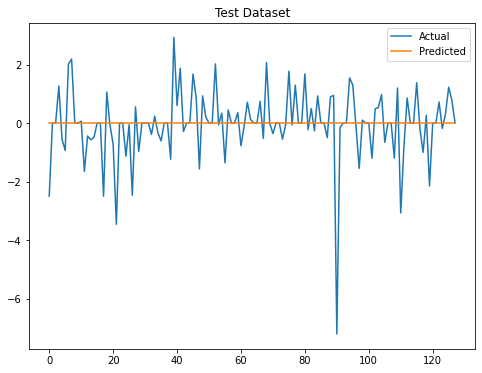

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 1s 45ms/step - loss: 1.4175 - root_mean_squared_error: 1.1906
rmse score on test set: [1.4174580574035645, 1.1905704736709595]
sMAPE score: 1.390625


In [ ]:
model = Sequential()
model.add(LSTM(300,input_shape=(X_train.shape[1],1), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation="relu"))
# Set Gradient clipping for exploding vanishing RNN problem 
model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5, 
                    verbose=0
                   )

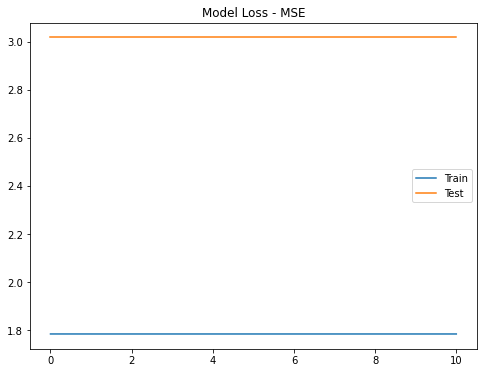

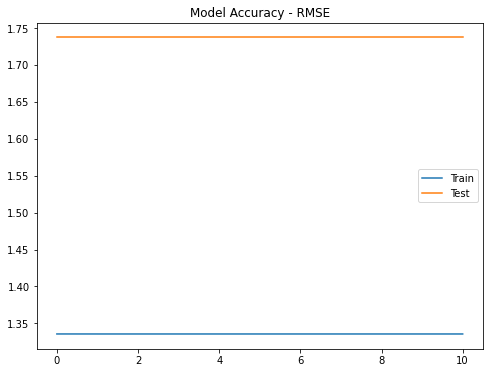

Text(0.5, 1.0, 'Test Dataset')

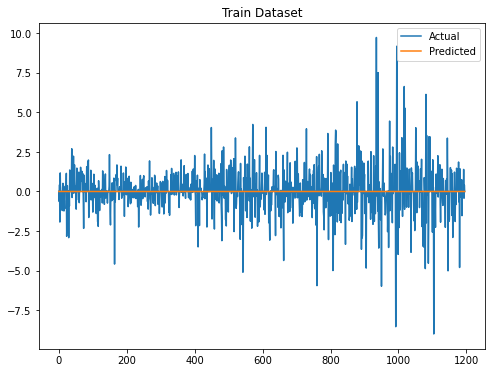

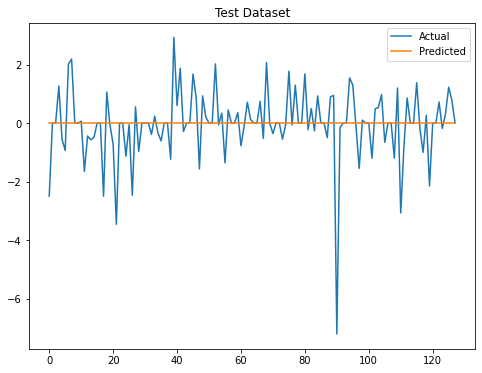

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])

# Make it pretty 
plt.title('Model Accuracy - RMSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")


mda score: 0.0
4/4 [==============================] - 0s 26ms/step - loss: 1.4175 - root_mean_squared_error: 1.1906
rmse score on test set: [1.4174580574035645, 1.1905704736709595]
sMAPE score: 1.390625


## Val Loss rather than RMSE

In [ ]:
model = Sequential()
model.add(LSTM(500,input_shape=(X_train.shape[1],1), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation="relu"))
# Set Gradient clipping for exploding vanishing RNN problem 
model.compile(loss='mse')

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=10)


history = model.fit(X_train,y_train,
                    epochs=300,
                    validation_split=0.1,
                    shuffle=False, 
                    callbacks=[early_stopping], 
                    batch_size=5, 
                    verbose=0
                   )

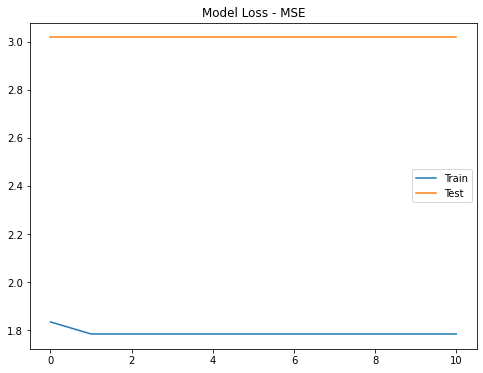

Text(0.5, 1.0, 'Test Dataset')

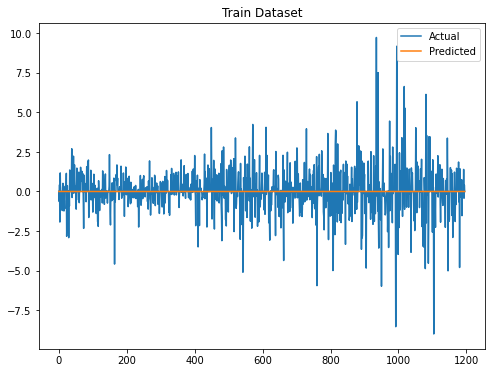

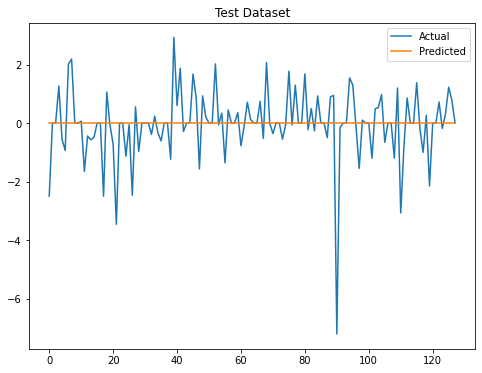

In [ ]:
plt.subplot2grid
# Plot train vs test ccuracy per epoch 
plt.figure(figsize=(8, 6))

# Use the history metrics 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty 
plt.title('Model Loss - MSE')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure(figsize=(8,6))
 
y_hat_train = model.predict(X_train)
plt.plot((y_train.reshape(-1,1)), label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

plt.figure(figsize=(8, 6))
 
y_hat = model.predict(X_test)
plt.plot((y_test.reshape(-1,1)), label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
mda = get_mda(y_test, y_hat)
print(f"mda score: {mda}")

print(f"rmse score on test set: {np.sqrt(model.evaluate(X_test, y_test))}")

sMAPE = mean_absolute_percentage_error(y_test, y_hat)
print(f"sMAPE score: {sMAPE}")

mda score: 0.0
4/4 [==============================] - 0s 40ms/step - loss: 1.4175
rmse score on test set: 1.1905704756139237
sMAPE score: 1.390625


# Baseline

In [ ]:
mse = mean_squared_error(test_diff[1:], test_diff.shift()[1:])
np.sqrt(mse)

1.7255885821706844

In [ ]:
mda = get_mda(test_diff[1:], test_diff.shift()[1:])
mda

0.19083969465648856

### Mean baseline

The mean baseline calculates the mean of the series in the training data and predicts the value for each test observation.

In [ ]:
train_diff_mean = train_diff.mean()
train_diff_mean

0.008301416503499687

In [ ]:
mse = mean_squared_error(test_diff, [train_diff_mean]*test_diff.shape[0])
np.sqrt(mse)

1.2016219013725453

In [ ]:
mda = get_mda(test_diff, [train_diff_mean]*test_diff.shape[0])
mda

0.14393939393939395